In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.tree import export_text
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import plot_tree
from xgboost import XGBClassifier

from patsy import dmatrices
import numpy as np
import pandas as pd

In [28]:
dataset = pd.read_excel(r"dataset_with_MACRO.xlsx")

In [29]:
pd.set_option('display.max_columns', None)

In [30]:
dataset.head(5)

,Organization Name,IPO Status,Company Type,Number of Employees,Last Funding Type,Last Funding Date,Founded Date,Founded Date Precision,Operating Status,Number of Founders,Number of Funding Rounds,Last Funding Amount (in USD),Last Equity Funding Amount (in USD),Total Equity Funding Amount (in USD),Total Funding Amount (in USD),Top 5 Investors,Number of Investors,Headquarters Regions,Industry Groups,Industries,Headquarters Location,Last Funding Year,Founded Year,Main Industry,Industry Name,Status__Private,CompanyType__For Profit,CompanyType__Non-profit,NumberEmployees__1-10,NumberEmployees__10001+,NumberEmployees__1001-5000,NumberEmployees__101-250,NumberEmployees__11-50,NumberEmployees__251-500,NumberEmployees__5001-10000,NumberEmployees__501-1000,NumberEmployees__51-100,FundingType__Angel,FundingType__Convertible Note,FundingType__Corporate Round,FundingType__Debt Financing,FundingType__Equity Crowdfunding,FundingType__Grant,FundingType__Initial Coin Offering,FundingType__Non-equity Assistance,FundingType__Post-IPO Debt,FundingType__Post-IPO Equity,FundingType__Post-IPO Secondary,FundingType__Pre-Seed,FundingType__Private Equity,FundingType__Secondary Market,FundingType__Seed,FundingType__Series A,FundingType__Series B,FundingType__Series C,FundingType__Series D,FundingType__Series E,FundingType__Series F,FundingType__Series G,FundingType__Series H,FundingType__Series I,FundingType__Series J,FundingType__Undisclosed,FundingType__Venture - Series Unknown,Industry_Aerospace/Defense,Industry_Air Transport,Industry_Apparel,Industry_Auto & Truck,Industry_Auto Parts,Industry_Bank (Money Center),Industry_Banks (Regional),Industry_Beverage (Soft),Industry_Brokerage & Investment Banking,Industry_Building Materials,Industry_Business & Consumer Services,Industry_Chemical (Basic),Industry_Chemical (Diversified),Industry_Chemical (Specialty),Industry_Coal & Related Energy,Industry_Computer Services,Industry_Computers/Peripherals,Industry_Diversified,Industry_Drugs (Biotechnology),Industry_Drugs (Pharmaceutical),Industry_Education,Industry_Electrical Equipment,Industry_Electronics (Consumer & Office),Industry_Electronics (General),Industry_Engineering/Construction,Industry_Entertainment,Industry_Environmental & Waste Services,Industry_Farming/Agriculture,Industry_Financial Svcs. (Non-bank & Insurance),Industry_Food Processing,Industry_Food Wholesalers,Industry_Green & Renewable Energy,Industry_Healthcare Support Services,Industry_Heathcare Information and Technology,Industry_Homebuilding,Industry_Hotel/Gaming,Industry_Household Products,Industry_Information Services,Industry_Insurance (General),Industry_Investments & Asset Management,Industry_Machinery,Industry_Power,Industry_Publishing & Newspapers,Industry_Real Estate (General/Diversified),Industry_Real Estate (Operations & Services),Industry_Recreation,Industry_Restaurant/Dining,Industry_Retail (Automotive),Industry_Retail (General),Industry_Semiconductor,Industry_Software (Entertainment),Industry_Software (Internet),Industry_Software (System & Application),Industry_Telecom. Equipment,Industry_Telecom. Services,Industry_Transportation,Industry_Transportation (Railroads),Macro Region,Region_Asia-Pacific,Region_EMEA,Region_Emerging Markets,Region_North America,LastFundingType__Angel,LastFundingType__Convertible Note,LastFundingType__Corporate Round,LastFundingType__Debt Financing,LastFundingType__Equity Crowdfunding,LastFundingType__Grant,LastFundingType__Initial Coin Offering,LastFundingType__Non-equity Assistance,LastFundingType__Post-IPO Debt,LastFundingType__Post-IPO Equity,LastFundingType__Post-IPO Secondary,LastFundingType__Pre-Seed,LastFundingType__Private Equity,LastFundingType__Secondary Market,LastFundingType__Seed,LastFundingType__Series A,LastFundingType__Series B,LastFundingType__Series C,LastFundingType__Series D,LastFundingType__Series E,LastFundingType__Series F,LastFundingType__Series G,LastFundingType__Series H,LastFundingType__Series I,LastFundingType__Series J,LastFundi

## Metrics into a Composite Score
Step-by-Step Computation:
Normalization of Metrics:

I normalized each financial metric to a range between 0 and 1. Normalization helps in standardizing different scales across metrics, making them comparable.
 
This scales each metric so that its minimum value becomes 0 and its maximum value becomes 1.

Composite Industry Factor Calculation:

I created a composite score by combining the normalized metrics using predefined weights:
- EV/Sales: 20%
- ROE: 30%
- Expected Growth (Next 5 Years): 30%
- Forward PE: 10%
- Percentage of Money Losing Firms: Inverted to reflect risk (10%)
### Combining Metrics into a Composite Score:
The composite score is calculated using the weighted sum of the normalized metrics. The formula used is:
Industry Factor = 0.2 × Normalized EV/Sales + 0.3 × Normalized ROE + 0.3 × Normalized Expected Growth + 0.1 × (1 − Normalized Money Losing Firms) + 0.1 × Normalized Forward PE


This results in a single score representing the overall favorability of each industry.

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant metrics and drop rows with missing values
metrics = dataset[['Industry Name', 'EV/Sales', 'ROE', 'Expected growth - next 5 years',
                   'Forward PE', '% of Money Losing firms (Trailing)']]
metrics_cleaned = metrics.dropna()

# Define the columns to normalize
normalize_columns = ['EV/Sales', 'ROE', 'Expected growth - next 5 years',
                     'Forward PE', '% of Money Losing firms (Trailing)']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the columns and store them with 'Normalized' prefix
normalized_data = scaler.fit_transform(metrics_cleaned[normalize_columns])
normalized_columns = ['Normalized ' + col for col in normalize_columns]
metrics_cleaned[normalized_columns] = normalized_data

# Invert 'Normalized % of Money Losing firms (Trailing)' since higher % is riskier
metrics_cleaned['Normalized % of Money Losing firms (Trailing)'] = 1 - metrics_cleaned['Normalized % of Money Losing firms (Trailing)']

# Calculate the Industry Factor with weightings
weights = {
    'Normalized EV/Sales': 0.2,
    'Normalized ROE': 0.3,
    'Normalized Expected growth - next 5 years': 0.3,
    'Normalized % of Money Losing firms (Trailing)': 0.1,
    'Normalized Forward PE': 0.1
}
metrics_cleaned['Industry Factor'] = metrics_cleaned[list(weights.keys())].dot(pd.Series(weights))

# Sort industries by their calculated factor
industry_factors = metrics_cleaned[['Industry Name', 'Industry Factor']].sort_values(by='Industry Factor', ascending=False)

# Create a dictionary for industry factors
industry_factor_dict = metrics_cleaned.set_index('Industry Name')['Industry Factor'].to_dict()

# Define the compute_variable function
def compute_variable(Industry_Groups, Founded_Date, IPO_Status, CompanyType__For_Profit,
                     Number_of_Funding_Rounds, EV_Sales, EV_EBITDA, Forward_PE,
                     Expected_growth_next_5_years, industry_factor_dict=industry_factor_dict,
                     current_year=2024, max_age=100, max_funding_rounds=10):
    # Calculate company age
    company_age = current_year - Founded_Date
    age_factor = 1 + (company_age / max_age)

    # IPO and company type factors
    ipo_factor = 1.2 if IPO_Status == 'Public' else 0.9
    company_type_factor = 1 if CompanyType__For_Profit else 0.8

    # Funding factor
    funding_factor = 1 + (Number_of_Funding_Rounds / max_funding_rounds)

    # Get industry factor, default to 1 if not found
    industry_factor = industry_factor_dict.get(Industry_Groups, 1)

    # Valuation factor, avoid division by zero
    if industry_factor != 0:
        valuation_factor = (EV_Sales + EV_EBITDA + Forward_PE) / industry_factor
    else:
        valuation_factor = EV_Sales + EV_EBITDA + Forward_PE

    # Growth factor
    growth_factor = 1 + (Expected_growth_next_5_years / 100)

    # Combine all factors
    composite_variable = (industry_factor * age_factor * ipo_factor *
                          company_type_factor * funding_factor *
                          valuation_factor * growth_factor)

    return composite_variable


In [35]:
dataset["Industry Groups"].unique()

array(['Information Technology, Real Estate, Software, Sustainability',
       'Energy, Financial Services, Lending and Investments, Natural Resources, Software, Sustainability, Transportation',
       'Blockchain and Cryptocurrency, Education, Internet Services, Software',
       ...,
       'Advertising, Clothing and Apparel, Commerce and Shopping, Design, Information Technology, Internet Services, Messaging and Telecommunications, Sales and Marketing',
       'Financial Services, Transportation',
       'Agriculture and Farming, Commerce and Shopping, Community and Lifestyle, Data and Analytics, Financial Services, Food and Beverage, Internet Services, Software'],
      dtype=object)

In [38]:
## use of the function is:
# recall the function compute_variable(Industry_Groups, Founded_Date, IPO_Status, CompanyType__For_Profit, Number_of_Funding_Rounds, 
#                                      EV_Sales, EV_EBITDA, Forward_PE, Expected_growth_next_5_years)


NameError: name 'industry_factor' is not defined

#### now all we need to do before running the models is to get only float, bool, int variables

In [5]:
columns_to_drop = [
    "Organization Name",
    "IPO Status",
    "Company Type",
    "Number of Employees",
    "Last Funding Type",
    "Last Funding Date",
    "Founded Date",
    "Founded Date Precision",
    "Operating Status",
    "Top 5 Investors",
    "Headquarters Location",
    "Industry Groups",
    "Industries",
    "Headquarters Regions",
    "Main Industry",
    "Industry Name",
    "Macro Region",
    "PEG Ratio",
    "Aggregate Mkt Cap/ Net Income (all firms)"

]
dataset = dataset.drop(columns=columns_to_drop, axis=1)

#### Need to be dropped all the variables which are not dummies, integers or float

In [6]:
dataset

,Number of Founders,Number of Funding Rounds,Last Funding Amount (in USD),Last Equity Funding Amount (in USD),Total Equity Funding Amount (in USD),Total Funding Amount (in USD),Number of Investors,Last Funding Year,Founded Year,Status__Private,CompanyType__For Profit,CompanyType__Non-profit,NumberEmployees__1-10,NumberEmployees__10001+,NumberEmployees__1001-5000,NumberEmployees__101-250,NumberEmployees__11-50,NumberEmployees__251-500,NumberEmployees__5001-10000,NumberEmployees__501-1000,NumberEmployees__51-100,FundingType__Angel,FundingType__Convertible Note,FundingType__Corporate Round,FundingType__Debt Financing,FundingType__Equity Crowdfunding,FundingType__Grant,FundingType__Initial Coin Offering,FundingType__Non-equity Assistance,FundingType__Post-IPO Debt,FundingType__Post-IPO Equity,FundingType__Post-IPO Secondary,FundingType__Pre-Seed,FundingType__Private Equity,FundingType__Secondary Market,FundingType__Seed,FundingType__Series A,FundingType__Series B,FundingType__Series C,FundingType__Series D,FundingType__Series E,FundingType__Series F,FundingType__Series G,FundingType__Series H,FundingType__Series I,FundingType__Series J,FundingType__Undisclosed,FundingType__Venture - Series Unknown,Industry_Aerospace/Defense,Industry_Air Transport,Industry_Apparel,Industry_Auto & Truck,Industry_Auto Parts,Industry_Bank (Money Center),Industry_Banks (Regional),Industry_Beverage (Soft),Industry_Brokerage & Investment Banking,Industry_Building Materials,Industry_Business & Consumer Services,Industry_Chemical (Basic),Industry_Chemical (Diversified),Industry_Chemical (Specialty),Industry_Coal & Related Energy,Industry_Computer Services,Industry_Computers/Peripherals,Industry_Diversified,Industry_Drugs (Biotechnology),Industry_Drugs (Pharmaceutical),Industry_Education,Industry_Electrical Equipment,Industry_Electronics (Consumer & Office),Industry_Electronics (General),Industry_Engineering/Construction,Industry_Entertainment,Industry_Environmental & Waste Services,Industry_Farming/Agriculture,Industry_Financial Svcs. (Non-bank & Insurance),Industry_Food Processing,Industry_Food Wholesalers,Industry_Green & Renewable Energy,Industry_Healthcare Support Services,Industry_Heathcare Information and Technology,Industry_Homebuilding,Industry_Hotel/Gaming,Industry_Household Products,Industry_Information Services,Industry_Insurance (General),Industry_Investments & Asset Management,Industry_Machinery,Industry_Power,Industry_Publishing & Newspapers,Industry_Real Estate (General/Diversified),Industry_Real Estate (Operations & Services),Industry_Recreation,Industry_Restaurant/Dining,Industry_Retail (Automotive),Industry_Retail (General),Industry_Semiconductor,Industry_Software (Entertainment),Industry_Software (Internet),Industry_Software (System & Application),Industry_Telecom. Equipment,Industry_Telecom. Services,Industry_Transportation,Industry_Transportation (Railroads),Region_Asia-Pacific,Region_EMEA,Region_Emerging Markets,Region_North America,LastFundingType__Angel,LastFundingType__Convertible Note,LastFundingType__Corporate Round,LastFundingType__Debt Financing,LastFundingType__Equity Crowdfunding,LastFundingType__Grant,LastFundingType__Initial Coin Offering,LastFundingType__Non-equity Assistance,LastFundingType__Post-IPO Debt,LastFundingType__Post-IPO Equity,LastFundingType__Post-IPO Secondary,LastFundingType__Pre-Seed,LastFundingType__Private Equity,LastFundingType__Secondary Market,LastFundingType__Seed,LastFundingType__Series A,LastFundingType__Series B,LastFundingType__Series C,LastFundingType__Series D,LastFundingType__Series E,LastFundingType__Series F,LastFundingType__Series G,LastFundingType__Series H,LastFundingType__Series I,LastFundingType__Series J,LastFundingType__Undisclosed,LastFundingType__Venture - Series Unknown,Price/Sales,Net Margin,EV/Sales,Pre-tax Operating Margin,PBV,ROE,EV/ Invested Capital,ROIC,EV/EBITDAR&D,EV/EBITDA,EV/EBIT,EV/EBIT (1-t),EV/EBITDAR&D2,EV/EBITDA3,EV/EBIT4,EV/EBIT (1-t)5,% of Money Losing firms (Traili

In [7]:
dataset["EV/EBIT (1-t)5"].describe()

count    9672.000000
mean       23.927394
std       237.332173
min     -6081.431016
25%        20.572607
50%        32.099992
75%        43.765672
max       197.446017
Name: EV/EBIT (1-t)5, dtype: float64

In [8]:
print(dataset.isna().sum().to_string())

Number of Founders                                                    0
Number of Funding Rounds                                              0
Last Funding Amount (in USD)                                          0
Last Equity Funding Amount (in USD)                                   0
Total Equity Funding Amount (in USD)                                  0
Total Funding Amount (in USD)                                         0
Number of Investors                                                   0
Last Funding Year                                                     0
Founded Year                                                          0
Status__Private                                                       0
CompanyType__For Profit                                               0
CompanyType__Non-profit                                               0
NumberEmployees__1-10                                                 0
NumberEmployees__10001+                                         

In [9]:
dataset["FundingXround"] = dataset["Total Funding Amount (in USD)"] / dataset["Number of Funding Rounds"]

In [10]:
dataset.dropna(inplace=True)

In [11]:
print(dataset.isna().sum().to_string())

Number of Founders                                                  0
Number of Funding Rounds                                            0
Last Funding Amount (in USD)                                        0
Last Equity Funding Amount (in USD)                                 0
Total Equity Funding Amount (in USD)                                0
Total Funding Amount (in USD)                                       0
Number of Investors                                                 0
Last Funding Year                                                   0
Founded Year                                                        0
Status__Private                                                     0
CompanyType__For Profit                                             0
CompanyType__Non-profit                                             0
NumberEmployees__1-10                                               0
NumberEmployees__10001+                                             0
NumberEmployees__100

# new session

In [32]:
X = dataset.drop('ROE', axis=1)
y = dataset['ROE']

In [33]:
bdt = GradientBoostingRegressor()
bdt.fit(X, y)
print(bdt.feature_importances_)
print(bdt.score(X, y))


[0.00000000e+00 2.96954981e-05 0.00000000e+00 3.90826378e-08
 6.60295052e-16 2.33167090e-17 3.38868870e-15 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.02785153e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.38632479e-15 2.56421187e-08
 4.49408322e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.61612238e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.95585170e-15 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.46387786e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.44798057e-04 0.00000000e+00
 2.35414034e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.60330012e-04 0.00000000e+00
 0.00000000e+00 0.000000

<Axes: title={'center': 'Feature Importance'}, xlabel='Feature'>

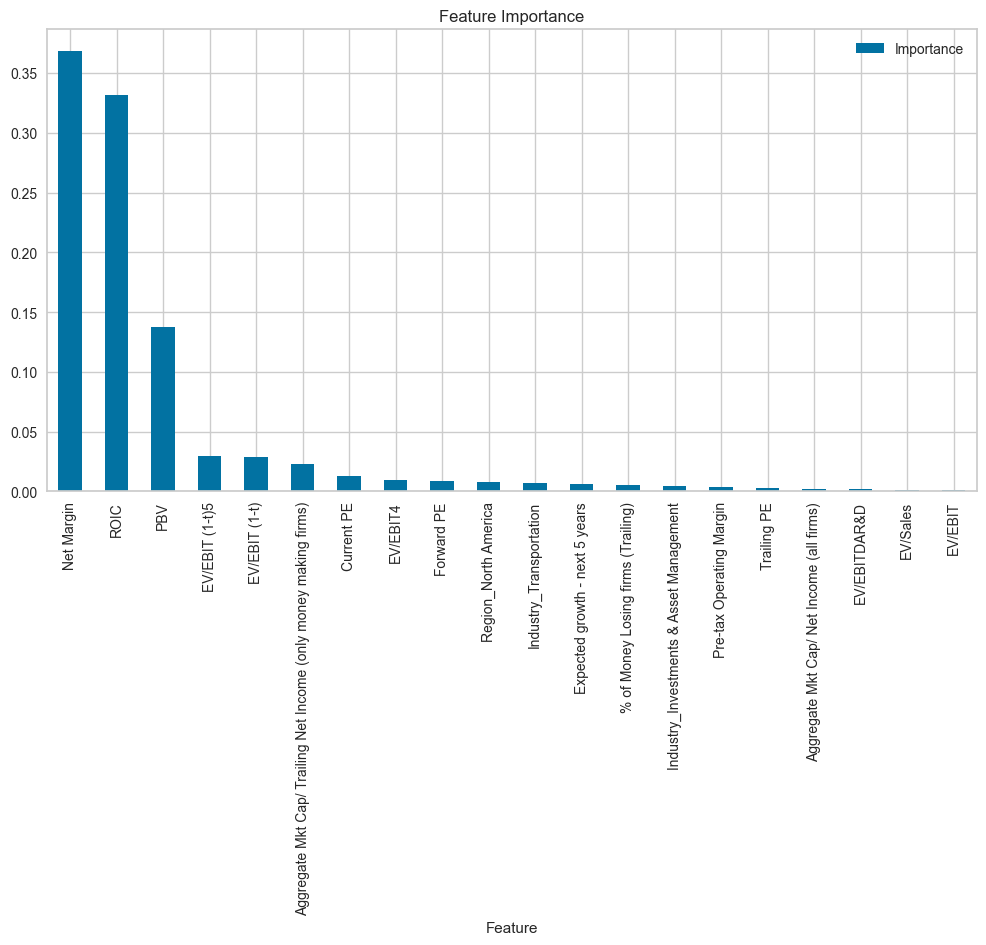

In [34]:
feature_names = dataset.columns
feature_names = feature_names.drop('ROE')  

feature_importances = bdt.feature_importances_

df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
df_sorted = df.sort_values(by='Importance', ascending=False)

df_sorted[:20].plot(x='Feature', y='Importance', kind='bar', title='Feature Importance', figsize=(12, 6))

In [35]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
dataset

## Pycaret

In [43]:
import pycaret as pc
from pycaret.regression import *

s = setup(dataset, 
            target='Total Funding Amount (in USD)', session_id=123)

,Description,Value
0,Session id,123
1,Target,Total Funding Amount (in USD)
2,Target type,Regression
3,Original data shape,"(9317, 158)"
4,Transformed data shape,"(9317, 158)"
5,Transformed train set shape,"(6521, 158)"
6,Transformed test set shape,"(2796, 158)"
7,Numeric features,157
8,Preprocess,True
9,Imputation type,simple


In [44]:
best = compare_models()

results_df = pull()

results_df = results_df.round(4)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,45115646.8583,49341937716748992.0000,207525756.0391,0.9586,3.1660,1828.9168,0.4010
et,Extra Trees Regressor,13343246.6656,44235952272446768.0000,175323958.3253,0.9584,1.3621,3.4962,1.4920
rf,Random Forest Regressor,22828090.5410,45511541337847536.0000,182281857.9446,0.9565,1.7739,5.1160,1.9390
xgboost,Extreme Gradient Boosting,22901984.8577,49532178394172040.0000,191167418.7430,0.9557,2.9730,616.7360,0.1100
dt,Decision Tree Regressor,17228745.7825,52061898617874352.0000,187116213.0367,0.9522,1.0397,1.2551,0.0430
knn,K Neighbors Regressor,47634515.5613,76547565099465632.0000,256072298.5036,0.9493,1.9471,1825.2339,0.0420
lightgbm,Light Gradient Boosting Machine,55341066.3367,109986745253433680.0000,312024855.0538,0.9245,3.0924,384.5684,0.2800
ridge,Ridge Regression,127816312.7063,144515736539508384.0000,365408652.9667,0.8841,3.9958,8335.3913,0.0320
lasso,Lasso Regression,131185889.3196,144652228318079904.0000,367088096.7419,0.8839,3.9925,5939.1920,0.5090
lr,Linear Regression,133501158.9510,144618524734380736.0000,367613576.9003,0.8837,4.0154,10974.3879,0.3970


c:\Users\JacopoBinati\anaconda3\envs\jacopo\lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [45]:
results_df

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,4.511565e+07,4.934194e+16,2.075258e+08,9.586000e-01,3.1660,1.828917e+03,0.401
et,Extra Trees Regressor,1.334325e+07,4.423595e+16,1.753240e+08,9.584000e-01,1.3621,3.496200e+00,1.492
rf,Random Forest Regressor,2.282809e+07,4.551154e+16,1.822819e+08,9.565000e-01,1.7739,5.116000e+00,1.939
xgboost,Extreme Gradient Boosting,2.290198e+07,4.953218e+16,1.911674e+08,9.557000e-01,2.9730,6.167360e+02,0.110
dt,Decision Tree Regressor,1.722875e+07,5.206190e+16,1.871162e+08,9.522000e-01,1.0397,1.255100e+00,0.043
knn,K Neighbors Regressor,4.763452e+07,7.654757e+16,2.560723e+08,9.493000e-01,1.9471,1.825234e+03,0.042
lightgbm,Light Gradient Boosting Machine,5.534107e+07,1.099867e+17,3.120249e+08,9.245000e-01,3.0924,3.845684e+02,0.280
ridge,Ridge Regression,1.278163e+08,1.445157e+17,3.654087e+08,8.841000e-01,3.9958,8.335391e+03,0.032
lasso,Lasso Regression,1.311859e+08,1.446522e+17,3.670881e+08,8.839000e-01,3.9925,5.939192e+03,0.509
lr,Linear Regression,1.335012e+08,1.446185e+17,3.676136e+08,8.837000e-01,4.0154,1.097439e+04,0.397


In [46]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## XG Boost Classifier

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Initialize the XGBClassifier
xgb = XGBRegressor(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

In [ ]:
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
print("\nTop 10 Feature Importances:")
for idx in sorted_idx[-10:]:  # Print top 10 features
    print(f"Feature {idx}: {feature_importance[idx]:.4f}")

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
feature_importance = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx[-10:].shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx[-10:]])
plt.yticks(pos, [f'Feature {idx}' for idx in sorted_idx[-10:]])
plt.title('Top 10 Feature Importance')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_xgb, X_train_scaled, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,7))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Random Forest Classifier

In [ ]:



param_grid = {
    'n_estimators': [50, 70],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rfr = RandomForestRegressor(
    random_state=42,
    criterion='mse',
    n_estimators=70,
    oob_score=True,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=4
)

grid_search.fit(X, y.values.ravel())

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Get the best estimator
best_rf = grid_search.best_estimator_

In [ ]:
y_holdout, X_holdout = dmatrices(formula, data_holdout, return_type='dataframe')

y_pred = best_rf.predict(X_holdout)


In [ ]:
mse = mean_squared_error(y_holdout, y_pred)
print("Mean Squared Error on holdout set: ", mse)

In [ ]:

cv_results = pd.DataFrame(grid_search.cv_results_)


# Metrics for the performance

In [ ]:
pivot_results = cv_results[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: -x["mean_test_score"],
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"]
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(2)

print("Cross-validation results:")
print(pivot_results)

## Feature Importance

In [ ]:
importances = best_rf.feature_importances_
feature_names = X.columns  # Get feature names from X
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Print feature importances
print("\nFeature Importances:")
for f, imp in zip([feature_names[i] for i in indices], importances[indices]):
    print(f"{f}: {imp:.4f}")

####################################################################

importances_xgb = best_xgb.feature_importances_
feature_names_xgb = X.columns
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances XGB")
plt.bar(range(X.shape[1]), importances_xgb[indices_xgb])
plt.xticks(range(X.shape[1]), [feature_names_xgb[i] for i in indices_xgb], rotation=90)
plt.tight_layout()
plt.show()

# Print feature importances
print("\nFeature Importances XGB:")
for f, imp in zip([feature_names_xgb[i] for i in indices_xgb], importances_xgb[indices_xgb]):
    print(f"{f}: {imp:.4f}")
